In [1]:
import numpy as np
import scipy.stats as sp
import matplotlib.pyplot as plt
%matplotlib inline

In [25]:
class CorrelatedBrownianMotion:
    
    # Class to create instances of multi-dimensional correlated geometric Brownian Motions,
    # either by providing one correlation coefficient to correlate all BMs or by
    # providing the whole correlation matrix. Correlation can be created by passing
    # to the constructor or by calling a 'correlate' method.
    # Results are of the form
    #
    #     X_t = mu*t + sigma*W_t
    #
    # where W_t is a d-dimensional standard BM with given correlation matrix,
    # mu and sigma are constant drift and diffusion vectors
    #
    # Parameters:
    # T: End of time span [0,T] (Integer)
    # N: Number of discretization steps (Integer)
    # d: Dimension (Integer)
    # x0: Starting value (Double)
    # mu: Drift (Double dx1 numpy array)
    # sigma: Diffusion (Double dx1 numpy array)
    # Corr: Correlation matrix of the BMs (Double dxd numpy array)
    # corrCoef: Correlation coefficient (Double) will be ignored if Corr is provided
    
    
    def __init__(self, T=1, N=10000, d=1, x0=0, mu=None, sigma=None, Corr=None, corrCoef=None):
        # Constructor:
        # initialize mu and sigma to zero and one vectors if not provided
        # perform Cholesky decomposition of correlation matrix to create 'Factors' for the BMs
        # use identity matrix if no input on correlation --> no correlation
        # print warning if both correlation coefficient and matrix is provided
        
        self.T = T
        self.N = N
        self.time = np.linspace(0, T, N)
        self.d = d if Corr is None else len(Corr)
        self.x0 = np.ones((d,1)) * x0
        self.mu = np.zeros((d,1)) if mu is None else np.reshape(mu, (d,1))
        self.sigma = np.ones((d,1)) if sigma is None else np.reshape(sigma, (d,1))
        self.Factors = np.eye(d)
        if corrCoef is not None:
            self.correlate(corrCoef)
        if Corr is not None:
            self.correlate(Corr)
        if corrCoef is not None and Corr is not None:
            print('Warning: corrCoef input was ignored: correlation created with matrix Corr')
        
    def correlate(self, Corr):
        # induces correlation to the BM
        # if correlation coefficient is provided, create correlation matrix first
        if np.isscalar(Corr):
            Corr = np.ones((self.d,self.d)) * Corr + np.diag([1-Corr] * self.d)
        self.Factors = np.linalg.cholesky(Corr)
        
    def generatePath(self):
        # generate a sample path (one for each dimension)
        # 1. Samples N-1 random variables ~N(0,dt) where dt is the step size and sums them (standard BM)
        # 2. add start value and drift, multiply with correlation factors, scale by sigma
        dt = self.T / (self.N - 1)
        increments = np.append(np.zeros((self.d,1)), sp.norm.rvs(scale=np.sqrt(dt), size=(self.d,self.N-1)), axis=1)
        return self.x0 + self.mu * self.time + self.sigma * (self.Factors @ np.cumsum(increments,axis=1))
    
    def getValue(self, t=None):
        # returns value for a given timepoint t (i.e. a random variable ~ N_d(x0+t*mu,t*sigma^2) with Corr)
        # Warning: simulating many timepoints doesn't give a BM! (no corr between timepoints)
        # only useful if only one timepoint is needed, i.e. for European option valuation
        if t is None:
            t = self.T
        return  self.x0 + self.mu * t + self.sigma * self.Factors @ sp.norm.rvs(scale=np.sqrt(t), size=(self.d,1))
    
    def plotPath(self, figsize=(10,5)):
        plt.figure(figsize=figsize)
        plt.plot(self.time, (self.generatePath()).T)
        plt.xlabel('$t$')
        plt.ylabel('$X_t$')
        plt.title('Sample path(s) of {}-dimensional Brownian Motion'.format(self.d))

        

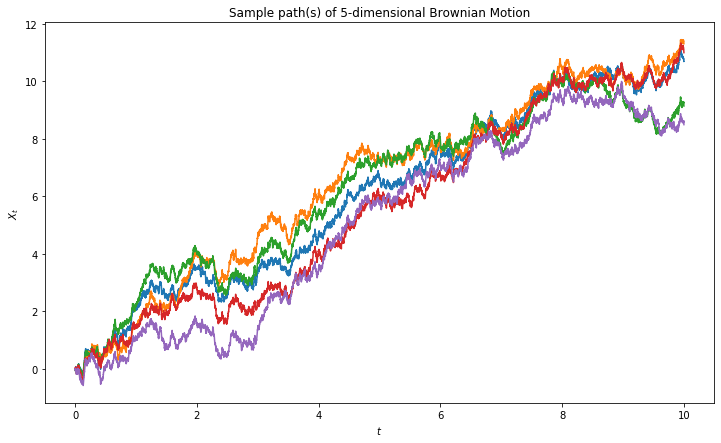

In [26]:
BM = CorrelatedBrownianMotion(T=10, d=5, corrCoef=0.8, mu=np.array([1]*5))
BM.plotPath(figsize=(12,7))

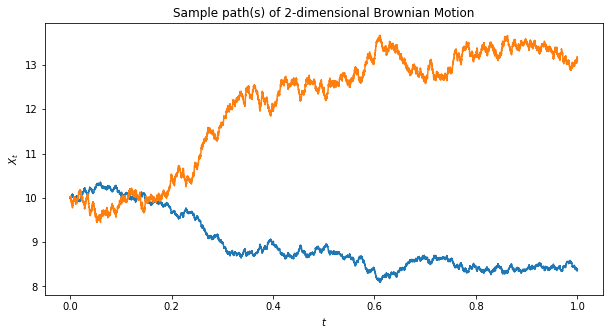

In [134]:
BM2 = CorrelatedBrownianMotion(d=2, x0=10, sigma=np.array([1,2]))
p = np.array([[1,-0.9],[-0.9,1]])
BM2.correlate(p)
BM2.plotPath()

In [122]:
import time

In [135]:
t = time.time()
vals = np.array([BM2.getValue() for _ in range(100000)]).reshape(100000,2)
print(np.mean(vals.T, axis=1))
print(np.std(vals.T, axis=1))
print('\n')
print(np.corrcoef(vals.T))
print('computing time: {}'.format(time.time()-t))

[10.00029914  9.99892755]
[0.99935886 1.99949143]


[[ 1.        -0.9002665]
 [-0.9002665  1.       ]]
computing time: 4.512080669403076


In [84]:
import seaborn as sns

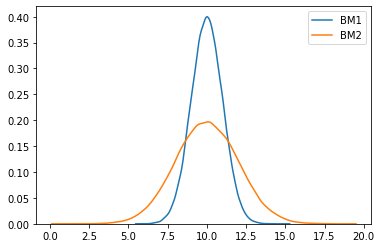

In [136]:
sns.kdeplot(vals.T[0], label='BM1')
sns.kdeplot(vals.T[1], label='BM2')

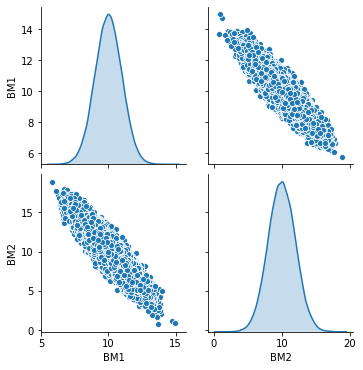

In [137]:
import pandas as pd
df = pd.DataFrame(vals, columns=['BM1','BM2'])
sns.pairplot(data=df, diag_kind='kde')

In [215]:
def BasketOptionPrice(x, K):
    return np.maximum(x.mean(axis=1) - K, 0).mean()

In [312]:
r = np.array([0.1]*5)
sig = np.array([2, 1.4, 0.8, 1, 0.9])
mu = r - 0.5 * sig ** 2
T = 3
d = 5
x0 = 0
p = 0.3
W = CorrelatedBrownianMotion(T=T, d=d, mu=mu, sigma=sig, x0=x0, corrCoef=p)

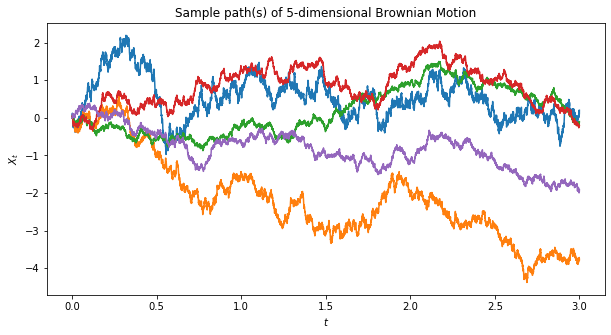

In [313]:
W.plotPath()

In [314]:
n = 100000

In [315]:
vals = np.array([W.getValue() for _ in range(n)]).reshape(n,d)

In [316]:
s0 = 20

In [317]:
stockPrices = s0 * np.exp(vals)

In [318]:
BasketOptionPrice(stockPrices, 13)

18.137439701976117

In [323]:
strikes = np.linspace(0,100)
prices = [BasketOptionPrice(stockPrices, K) for K in strikes]

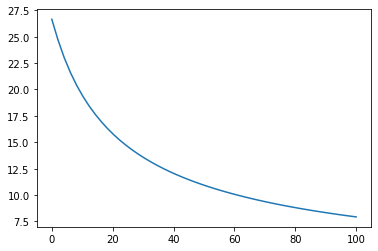

In [324]:
plt.plot(strikes,prices)